In [1]:
import time
import numpy as np
from queue import Queue
from collections import defaultdict

class PreDeCon():
    def __init__(self, minPts=3, eps=1.0, delta = 0.25, lambda_ = 1, kappa = 100):
        self.minPts = minPts
        self.eps = eps
        self.delta = delta
        self.lambda_ = lambda_
        self.kappa = kappa

        self.num_points = 0
        self.num_features = 0
        self.X = None
        self._neighborhoods = None
        self._pref_weighted_neighborhoods = None
        self._cluster_of_points = None

        self._NOISE = -1 # cluster ID for all noise points

        self.performance = defaultdict(int)

    def fit(self, X):
        t0 = time.perf_counter()

        self.num_points = X.shape[0]
        self.num_features = X.shape[1]
        self.X = X

        # caching neighborhoods in dicts
        neighborhoods = {}
        for p in self.X:
            N = self._eps_neighborhood(p)
            neighborhoods[p.tobytes()] = N
        self._neighborhoods = neighborhoods

        t1 = time.perf_counter()
        print(f"{t1-t0:>8.4f}s neighborhoods")

        pref_weighted_neighborhoods = {}
        for p in self.X:
            N_w = self._preference_weighted_eps_neighborhood(p)
            pref_weighted_neighborhoods[p.tobytes()] = N_w
        self._pref_weighted_neighborhoods = pref_weighted_neighborhoods

        t2 = time.perf_counter()
        print(f"{t2-t1:>8.4f}s weighted neighborhoods")

    	# see Figure 4 of the PreDeCon_Paper.pdf for the Pseudocode
        self._cluster_of_points = {}
        clusterID = 0

        for point in self.X:
            if self._is_core_point(point):
                # ensures IDs that only increase by 1
                try:
                    self._cluster_of_points[point.tobytes()]
                except KeyError:
                    clusterID += 1

                queue = Queue()

                for n in self._pref_neighborhood_of_point(point):
                    queue.put(n)

                while not queue.empty():
                    q = queue.get()
                    R = [x for x in self.X if self._is_directly_preference_weighted_reachable(q,x)]

                    for x in R:
                        try:
                            if self._cluster_of_points[x.tobytes()] == self._NOISE:
                                self._cluster_of_points[x.tobytes()] = clusterID

                        # if a KeyError occured, x was unclassified
                        except KeyError:
                            self._cluster_of_points[x.tobytes()] = clusterID
                            queue.put(x)

            else: # point is noise
                self._cluster_of_points[point.tobytes()] = self._NOISE
        
        t3 = time.perf_counter()
        print(f"{t3-t2:>8.4f}s clusters")
        
        self.labels = []
        for point in self.X:
            self.labels.append(self._cluster_of_points[point.tobytes()])

        t4 = time.perf_counter()
        print(f"{t4-t3:>8.4f}s labels")
        print(f"{t4-t0:>8.4f}s overall")
        
        # self._cluster_of_points = None

    def _neighborhood_of_point(self, p):
        # return cached neighborhood for points in X, calculate for unknown points
        try:
            return self._neighborhoods[p.tobytes()]
        except KeyError:
            return self._eps_neighborhood(p)

    def _pref_neighborhood_of_point(self, p):
        # return cached neighborhood for points in X, calculate for unknown points
        try:
            return self._pref_weighted_neighborhoods[p.tobytes()]
        except KeyError:
            self._preference_weighted_eps_neighborhood(p)

    def _variance_along_attribute(self, p, j):
        t0 = time.perf_counter_ns()
        N = self._neighborhood_of_point(p)
        sum = np.sum(np.abs(N[:, j] - p[j]))
        result = sum / len(N)
        self.performance['vaa'] += time.perf_counter_ns() - t0
        return result

    def _subspace_preference_vector(self, p):
        t0 = time.perf_counter_ns()
        var = self._variance_along_attribute
        d = self.num_features
        w = [(1 if var(p,j) > self.delta else self.kappa) for j in range(d)]
        result = np.array(w)
        self.performance['spv'] += time.perf_counter_ns() - t0
        return result

    def _subspace_preference_dimensionality(self, p):
        t0 = time.perf_counter_ns()
        result = np.count_nonzero(self._subspace_preference_vector(p) == self.kappa)
        self.performance['spd'] += time.perf_counter_ns() - t0
        return result

    def _preference_weighted_similarity_measure(self, p, q):
        t0 = time.perf_counter_ns()
        result = np.sqrt(np.sum(self._subspace_preference_vector(p) * (p - q)**2))
        self.performance['pwsm'] += time.perf_counter_ns() - t0
        return result

    def _general_preference_weighted_similarity_measure(self, p, q):
        t0 = time.perf_counter_ns()
        dist = self._preference_weighted_similarity_measure
        result = np.maximum(dist(p,q), dist(q,p))
        self.performance['gpwsm'] += time.perf_counter_ns() - t0
        return result

    def _eps_neighborhood(self, p):
        t0 = time.perf_counter_ns()
        result = np.array([q for q in self.X if np.linalg.norm(p-q) <= self.eps])
        self.performance['en'] += time.perf_counter_ns() - t0
        return result

    def _preference_weighted_eps_neighborhood(self, o):
        t0 = time.perf_counter_ns()
        dist_pref = self._general_preference_weighted_similarity_measure
        result = np.array([x for x in self.X if dist_pref(o,x) <= self.eps])
        self.performance['pwen'] += time.perf_counter_ns() - t0
        return result

    def _is_core_point(self, p):
        t0 = time.perf_counter_ns()
        pdim = self._subspace_preference_dimensionality(p)
        N_w = self._pref_neighborhood_of_point(p)
        result = pdim <= self.lambda_ and len(N_w) >= self.minPts
        self.performance['icp'] += time.perf_counter_ns() - t0
        return result

    def _is_directly_preference_weighted_reachable(self, q, p):
        t0 = time.perf_counter_ns()
        if (self._pref_neighborhood_of_point(q) == p).any():
            # if the point is in the neighborhood (condition 3), check if condition 1 and 2 are fulfilled
            result = self._is_core_point(q) and self._subspace_preference_dimensionality(p) <= self.lambda_
            self.performance['idpwr'] += time.perf_counter_ns() - t0
            return result

        # the point cannot be directly reachable since condition 3 was not fulfilled, therefore return False
        self.performance['idpwr'] += time.perf_counter_ns() - t0
        return False

    def _is_noise_point(self, p):
        return self._cluster_of_points[p.tobytes()] == self._NOISE


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as NMI

  0.0865s neighborhoods
  1.0172s weighted neighborhoods
  2.3795s clusters
  0.0002s labels
  3.4834s overall

  0.0862s en
  1.4969s vaa
  1.9074s spv
  0.9413s pwsm
  0.9947s gpwsm
  1.0166s pwen
  1.4706s spd
  0.8033s icp
  2.2324s idpwr


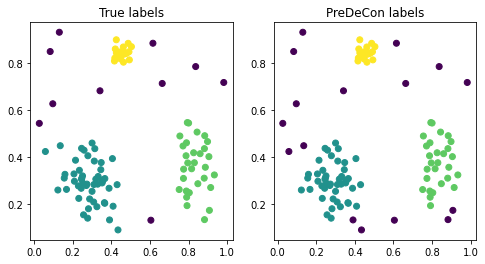

In [3]:
dataset = 'multiple-gaussian-2d'
path = os.path.join('..', 'algorithm_verification', 'datasets', dataset, dataset + '.csv')

data = np.loadtxt(path, delimiter=' ')
X, true_labels = data[:,:-1], data[:,-1]

predecon = PreDeCon(minPts=8, eps=1, delta=0.5, lambda_=2, kappa=100)
predecon.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=true_labels)
ax[0].set_title("True labels")

ax[1].scatter(X[:,0], X[:,1], c=predecon.labels)
ax[1].set_title("PreDeCon labels")

print()

for key, value in predecon.performance.items():
    print(f"{value / 1000_000_000:>8.4f}s {key}")

  0.0980s neighborhoods
 12.0037s weighted neighborhoods
 34.0771s clusters
  0.0002s labels

  0.0952s en
 34.2427s vaa
 34.7788s spv
 12.0478s pwsm
 12.1146s gpwsm
 12.1417s pwen
 23.4637s spd
 12.0118s icp

  

  0.0952s en
 34.2427s vaa
 34.7788s spv
 12.0478s pwsm
 12.1146s gpwsm
 12.1417s pwen
 23.4637s spd
 12.0118s icp


In [4]:
N = np.random.rand(5, 5)
p = np.random.rand(5, 1)

np.isclose(N, p)

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])